# Whitening on Speech Spectograms

Computes the whitening transformation on clean and noisy audio files.  

Libraries used:
1) Numpy - for numerical computations such as eig(), matmul(), fft(), dot operator
2) Scipy - to read the .wav file
3) Matplotlib - to plot the spectogram

In [66]:
from scipy.io import wavfile
from scipy import signal
import matplotlib.pyplot as plt
import os
from numpy import matmul
import numpy as np
import numpy.linalg as linalg
from math import sqrt

### Function read_audio()

Reads the .wav file and returns the sample_rate and the wav_file.

In [67]:
def read_audio(input):
    sample_rate, wav_file = wavfile.read('speechFiles/'+input+'.wav')
    print("Sample rate", sample_rate)
    
    length = len(wav_file)
    
    print(length, wav_file)
    

    time_frame = length / sample_rate
    
    time = [i/sample_rate for i in range(len(wav_file))]
    plt.plot(time, wav_file)
    plt.show()
    
    return sample_rate, wav_file

### Function fft()

<strong> Window size </strong> = 25 ms = 25 / 1000 * 16000 = 400 samples

<strong> Shift </strong> = 10 ms = 10 / 1000 * 16000 = 160 samples

##### For each window, computes 256 point magnitude FFT and retains the first 128 dimensions in each window, apply log of the magnitude of the FFT.

##### Returns the spectogram of size 128 x 311.

In [68]:
def fft(sample_rate, wav_file):
    length = len(wav_file)
    
    start = 0
    window_size = 25 * sample_rate // 1000

    shift = 10 * sample_rate // 1000
    
    print("Windows size", window_size)
    print("Shift", shift)

    i = 0
    while start + window_size <= length:    
        fft = np.log(np.abs(np.fft.fft(wav_file[start:start+window_size], n=256)[:128]))
        
        if start == 0:
            spectogram = fft
        else:
            spectogram = np.vstack((spectogram, fft))

        start += shift
        i+=1
    
    return spectogram

### Function plot_spectogram()

Plots the given spectogram.

In [69]:
def plot_spectogram(spectogram):
    t = [i for i in range(311)]
    f = [i for i in range(128)]

    plt.pcolormesh(t, f, spectogram.T)
    plt.colorbar()
    plt.show()

#### Reads the clean.wav audio file, computes and plots it's spectogram

Sample rate 16000
50000 [-10 -12 -30 ...   2   5 -22]


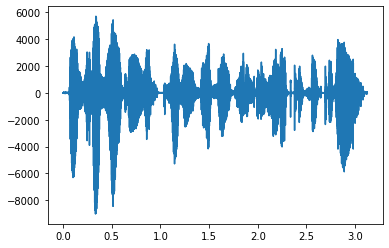

Windows size 400
Shift 160


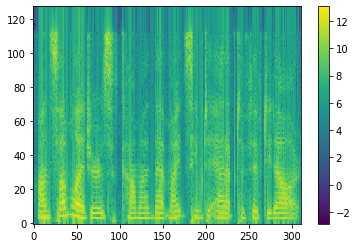

In [70]:
sample_rate, clean_wav = read_audio('clean')
clean_spec = fft(sample_rate, clean_wav)
plot_spectogram(clean_spec)

Sample rate 16000
50000 [   6 -149  106 ...  -77  249   28]


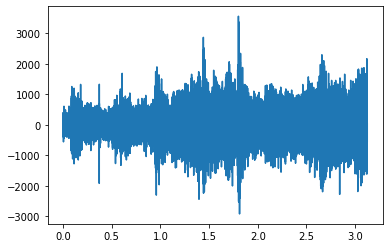

Windows size 400
Shift 160


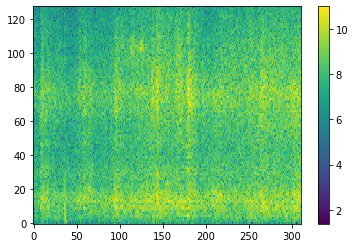

In [71]:
sample_rate, noise_wav = read_audio('noise')
noise_spec = fft(sample_rate, noise_wav)
plot_spectogram(noise_spec)

#### Reads the noisy.wav audio file, computes and plots it's spectogram

Sample rate 16000
50000 [ -7 -87  23 ... -37 129  -8]


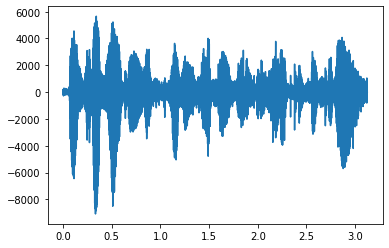

Windows size 400
Shift 160


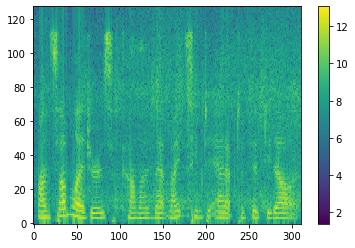

In [72]:
sample_rate, noisy_wav = read_audio('noisy')
noisy_spec = fft(sample_rate, noisy_wav)
plot_spectogram(noisy_spec)

### Class PCA

#### Function fit()

##### Performs Eigen Analysis on $ \frac{1}{N}X^TX $

##### Returns the Eigen vectors and Eigen values sorted based on the magnitude of the Eigen values in non-increasing order

In [73]:
class PCA:
    def __init__(self):
        self.eig_vectors = None
        
    def fit(self, X):
        N = len(X)
        
        data = X.T.dot(X) / N
        
        eigenValues, eigenVectors = linalg.eig(data)
        
        idx = eigenValues.argsort()[::-1]   
        eigenValues = eigenValues[idx]
        eigenVectors = eigenVectors[:,idx]
        
        self.eig_vectors = eigenVectors
        
        return eigenValues, eigenVectors        

### Calculates mean along the given axis

In [74]:
def calculate_mean(X, axis):
    mean = np.sum(X, axis=axis)
    mean = mean / X.shape[axis]
    
    return mean

### Class Whiten

#### Function fit()

Calculates the mean (m) centered data from the input spectogram

Gets the Eigen Vectors W and Eigen Values $\Lambda = diag(\lambda) $ for the mean centered data from the PCA class 

Stores $ \Lambda^{-1/2} $, W and mean on it's class attributes.

#### Function transform()

Performs the Whitening transformation

$ y_n = \Lambda^{-1/2}W^T(X - m) $

#### Function fit_transform()

Performs fit and transform on the same data distribution

In [75]:
class whiten:
    
    def __init__(self):
        self.mean = None
        self.lambdaa = None
        self.eigenVectors = None
        
    def fit(self, spectogram):
        pca = PCA()
    
        mean =  calculate_mean(spectogram, axis = 1).reshape(1,128)

        X_c = spectogram - mean.T
    
        eigenValues, eigenVectors = pca.fit(X_c.T)

        lamb = np.diag(1/(eigenValues**0.5))
        lamb = lamb.real.round(5)
        
        self.mean = mean
        self.lambdaa = lamb
        self.eigenVectors = eigenVectors
        
    def transform(self, spectogram):

        X_c = spectogram - self.mean.T

        y_n = self.lambdaa.dot(self.eigenVectors.T).dot(X_c)
        print("Whitened data", y_n.shape, y_n)
        
        return y_n
    
    def fit_transform(self, spectogram1, spectogram2):
        fit(spectogram1)
        return transform(spectogram2)

#### Function calculate_average_covariance()

Calculates the covariance matrix of the Whitened data

Find the average of the absolute value of the non-diagonal entries of the sampled covariance matrix of the whitened data.

In [76]:
def calculate_average_covariance(whitened_data):
    avg = 0
    
    mean = calculate_mean(whitened_data, 1).reshape(128, 1)
    
    print("Mean", mean.reshape(1,128).round(5))

    cov = ((whitened_data - mean).dot((whitened_data - mean).T) / whitened_data.shape[1]).round(5)
    
    print("Covariance matrix", cov)
    for i in range(len(cov)):
        for j in range(len(cov)):
            if i != j:
                avg += abs(cov[i][j])
                
    print("\nAverage value of Non-diagonal entries in Covariance matrix = ", avg / (len(cov)*len(cov) - len(cov)))

### Question 3) a)

#### Calculates Hyperparamaters of Whitening transformation based on the clean audio spectogram

In [77]:
whiten_data = whiten()

whiten_data.fit(clean_spec.T)

#### Performs Whitening transformation on the same clean audio spectogram

Plots the Whitened clean spectogram

Whitened data (128, 311) [[ 2.54210034  2.4720396   2.39113543 ...  0.78834551  1.96552973
   1.95524897]
 [-0.29920575 -0.11373301 -0.14413766 ...  0.2572571   0.39043647
  -0.08753454]
 [-0.4412063  -1.27000928 -1.42445034 ...  0.55334219 -1.85830311
  -0.65171388]
 ...
 [ 0.80074988 -0.4324475  -2.65889795 ...  0.63357652  1.39570888
  -2.64113189]
 [ 1.40552521 -1.67818035 -2.36045033 ... -0.14681656 -2.77626552
   1.21202408]
 [ 1.1485384   0.09512753 -0.03802409 ... -0.37497879  2.98390586
   1.65098202]]


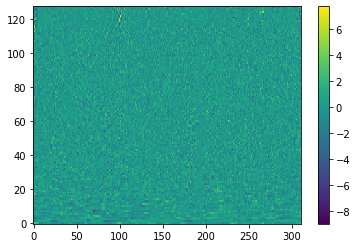

In [78]:
Y_clean_clean = whiten_data.transform(clean_spec.T)

plot_spectogram(Y_clean_clean.T)

#### Calculates the average of the absolute value of the non-diagonal entries of the sampled covariance matrix of the whitened clean data.

<strong> Average value of Non-diagonal entries in Covariance matrix </strong> =  0.0

In [79]:
calculate_average_covariance(Y_clean_clean)

Mean [[ 0. -0.  0. -0.  0.  0. -0.  0.  0. -0.  0.  0.  0. -0. -0. -0.  0. -0.
  -0.  0. -0. -0. -0. -0.  0. -0. -0.  0. -0.  0. -0. -0. -0. -0.  0.  0.
   0.  0.  0.  0.  0. -0.  0. -0.  0.  0.  0.  0.  0.  0. -0.  0. -0.  0.
   0. -0.  0. -0.  0.  0.  0.  0. -0. -0. -0. -0. -0. -0. -0. -0.  0. -0.
   0. -0. -0. -0. -0. -0. -0.  0.  0. -0. -0.  0.  0. -0.  0.  0. -0.  0.
  -0.  0.  0.  0. -0.  0. -0. -0.  0. -0.  0. -0. -0. -0. -0. -0. -0. -0.
  -0.  0. -0. -0. -0.  0. -0.  0.  0.  0.  0. -0. -0. -0. -0. -0.  0. -0.
   0. -0.]]
Covariance matrix [[ 1.       0.       0.      ...  0.       0.       0.     ]
 [ 0.       1.00001  0.      ...  0.       0.      -0.     ]
 [ 0.       0.       1.      ... -0.      -0.      -0.     ]
 ...
 [ 0.       0.      -0.      ...  1.       0.      -0.     ]
 [ 0.       0.      -0.      ...  0.       1.      -0.     ]
 [ 0.      -0.      -0.      ... -0.      -0.       1.     ]]

Average value of Non-diagonal entries in Covariance matrix =  0.0


#### Performs Whitening transformation on the differen noisy audio spectogram

Plots the Whitened noisy spectogram

Whitened data (128, 311) [[  0.30316635   0.32174987   0.35453408 ...  -0.93143445  -0.90962987
   -0.860836  ]
 [ -0.86954027  -0.97501214  -0.764798   ...  -0.73505083  -0.85237167
   -0.95353828]
 [  0.19977065   0.34196493   0.14825593 ...   0.18773501  -0.12396916
   -0.36023522]
 ...
 [ 20.26688261 -11.10999092 -30.595131   ...   5.3754646   14.73690777
  -23.40951227]
 [-20.72922086  10.00737014  -5.73970335 ... -11.79214451  -2.85947827
  -29.76831218]
 [ 10.12312376   6.87289718  -1.3857616  ... -18.76592079  -8.72090162
    9.72440304]]


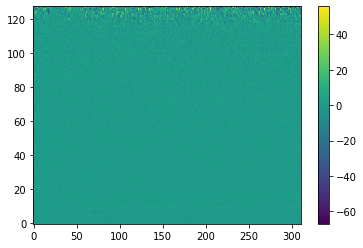

In [80]:
Y_clean_noisy = whiten_data.transform(noisy_spec.T)

plot_spectogram(Y_clean_noisy.T)

#### Calculates the average of the absolute value of the non-diagonal entries of the sampled covariance matrix of the whitened noisy data.

<strong> Average value of Non-diagonal entries in Covariance matrix </strong> =  0.18946

In [81]:
calculate_average_covariance(Y_clean_noisy)

Mean [[-0.86001 -0.44514  0.05244 -0.25733 -0.3382   0.52558 -0.41274 -0.83123
   0.14482  0.28371  1.14754 -0.28222 -0.22853 -0.02704  0.29637 -0.17502
   0.28308  0.26873  0.11716 -0.21418  0.00648 -0.11259 -0.47178 -0.03928
  -0.23998 -0.436    0.01685  0.2353  -0.13854 -0.41042  0.07585 -0.46826
   0.27474  0.21779 -0.02677 -0.08221 -0.11478 -0.1704   0.2615  -0.10956
   0.13659 -0.30338 -0.16931  0.1448  -0.16904  0.48653  0.26206  0.16408
   0.14371  0.25632  0.03825 -0.19665 -0.23472  0.07279  0.34943  0.20682
  -0.14695 -0.06526  0.06698  0.05527  0.23498 -0.09106  0.13791 -0.01192
   0.27786 -0.27562 -0.1296  -0.12513  0.21522 -0.19044 -0.0061   0.03351
  -0.09772  0.3015  -0.15725 -0.10413  0.07885 -0.27608 -0.1492  -0.30055
  -0.30801  0.15417  0.27758 -0.3725   0.53199 -0.25041 -0.23447  0.14
   0.05589 -0.04699 -0.21431 -0.13815  0.23473  0.13418  0.12518  0.16068
  -0.28842  0.06175 -0.00917  0.49127 -0.58899 -0.27509 -0.05453 -0.36873
   0.40224  0.0402  -0.12655  0.2524

### Question 3) b)

#### Calculates Hyperparamaters of Whitening transformation based on the noisy audio spectogram

In [82]:
whiten_data = whiten()

whiten_data.fit(noise_spec.T)

#### Performs Whitening transformation on the same noisy audio spectogram

Plots the Whitened noisy spectogram

Whitened data (128, 311) [[-3.46071706 -3.53282522 -3.6363269  ... -0.1653952  -0.23948393
  -0.37052799]
 [-0.96817781 -1.73779651 -1.39425338 ... -0.11246286 -0.08712764
   0.07984924]
 [-0.29168546 -0.13180722 -1.28434648 ...  0.13383685 -0.10367154
  -0.39716387]
 ...
 [ 0.07197797 -1.97583539 -0.19335989 ...  1.58431141  1.02522319
  -1.40155651]
 [ 0.25581056 -0.36178714  1.51673899 ...  0.6811201   0.22237671
   0.18124917]
 [ 2.68863643  1.16605539  0.62085738 ... -0.57804948 -0.70881488
   1.03898524]]


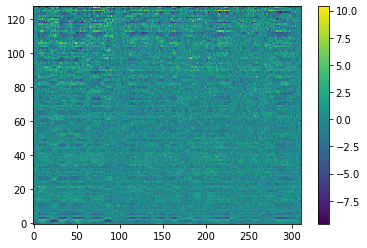

In [83]:
Y_noisy_noisy = whiten_data.transform(noisy_spec.T)

plot_spectogram(Y_noisy_noisy.T)

#### Calculates the average of the absolute value of the non-diagonal entries of the sampled covariance matrix of the whitened noisy data.

<strong> Average value of Non-diagonal entries in Covariance matrix </strong> =  0

In [84]:
calculate_average_covariance(Y_noisy_noisy)

Mean [[-4.41300e-01 -1.74900e-02  1.57917e+00 -1.42694e+00  5.01610e-01
  -1.38485e+00 -1.14040e-01 -1.26710e-01  4.25760e-01 -2.65020e-01
  -2.99600e-02 -4.82820e-01  1.11080e-01  1.38530e-01  4.94460e-01
  -1.68500e-01  4.14780e-01 -1.35780e-01  3.52440e-01 -1.86360e-01
   1.80460e-01  7.84820e-01  3.29900e-01 -8.15040e-01  3.40280e-01
   2.32650e-01 -4.78450e-01 -4.71870e-01  2.66030e-01  3.49300e-02
   4.63830e-01 -3.24920e-01  3.57350e-01 -7.13780e-01  2.58830e-01
   4.93200e-01  1.88200e-01  7.14600e-01 -2.01110e-01  4.74930e-01
   3.59080e-01  1.97090e-01 -4.03040e-01 -5.11290e-01  3.03340e-01
   3.04930e-01 -3.42730e-01  2.71700e-01  1.38730e-01 -5.94400e-01
   2.94420e-01 -3.07990e-01  3.49960e-01  1.41700e-02 -5.21440e-01
   1.70820e-01 -2.55570e-01 -6.64000e-02 -3.60290e-01 -9.74400e-02
  -2.78940e-01 -1.95660e-01  9.83670e-01  7.41130e-01 -2.35090e-01
   1.03300e-02 -7.31670e-01 -1.18460e-01 -5.54670e-01  4.88070e-01
  -6.29120e-01 -1.96220e-01  4.45380e-01 -7.85920e-01 -8.

#### Performs Whitening transformation on the different clean audio spectogram

Plots the Whitened clean spectogram

Whitened data (128, 311) [[-9.40490991e+00 -9.22904435e+00 -8.99398429e+00 ... -4.98440343e+00
  -8.10096172e+00 -8.01434063e+00]
 [-2.72241736e+00 -1.40102496e+00 -1.09463269e+00 ... -8.77452259e-01
   6.67493228e-01 -5.95175587e-01]
 [ 6.56914020e-01  7.58099657e-01 -6.16843165e-01 ...  1.78696683e+00
   1.66082506e-01 -4.91676495e-01]
 ...
 [ 2.68266096e+00  1.35563714e+00  2.35441484e+00 ...  1.27891674e+00
   3.83805681e+00  3.93647235e+00]
 [ 1.50497207e+00  1.02965018e+00  3.11387724e+00 ... -3.10922902e+00
  -3.25006483e+00 -3.20967477e+00]
 [-7.04077400e-03  6.69506227e+00  6.30418167e-01 ...  1.27197092e+00
  -1.13001367e+00  6.24816280e+00]]


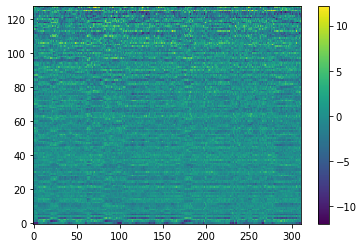

In [85]:
Y_noisy_clean = whiten_data.transform(clean_spec.T)

plot_spectogram(Y_noisy_clean.T)

#### Calculates the average of the absolute value of the non-diagonal entries of the sampled covariance matrix of the whitened clean data.

<strong> Average value of Non-diagonal entries in Covariance matrix </strong> =  0.12322

In [86]:
calculate_average_covariance(Y_noisy_clean)

Mean [[-2.81234e+00 -1.83690e-01  2.05697e+00 -2.35497e+00  8.58250e-01
  -2.39490e+00  8.92500e-02 -1.52760e-01  5.38040e-01 -6.24000e-03
  -2.17070e-01 -8.38410e-01  4.64140e-01  2.70380e-01  7.97790e-01
  -2.37070e-01  4.59890e-01 -4.15050e-01  6.53930e-01 -6.50730e-01
  -9.19600e-02  1.54578e+00  4.95290e-01 -1.71631e+00  2.85860e-01
   5.20720e-01 -7.15140e-01 -7.61800e-01  4.05000e-03  5.81200e-02
   1.14857e+00 -7.03610e-01 -7.84000e-02 -7.77260e-01  4.30740e-01
   4.79350e-01  1.25870e-01  1.34258e+00 -3.14530e-01  5.72590e-01
   7.85790e-01  8.82300e-02 -3.15240e-01 -1.18600e-01  8.16920e-01
   6.11680e-01 -1.00019e+00  5.21570e-01  3.44750e-01 -4.88560e-01
   5.93590e-01 -5.14000e-01  8.41590e-01 -1.29230e-01 -6.86040e-01
   9.60330e-01 -1.95050e-01 -7.06000e-02 -8.51030e-01 -3.13230e-01
  -2.69190e-01 -9.50400e-02  1.21100e+00  1.40814e+00  1.11040e-01
  -6.28500e-02 -1.36529e+00 -7.44040e-01 -6.73430e-01  9.50210e-01
  -2.03100e-01  1.80170e-01  6.97070e-01 -6.67550e-01 -4.

Whitened data (128, 311) [[-1.8205782  -1.90155143 -2.0576194  ...  1.29947536  1.36991644
   1.25770918]
 [-0.37263089 -1.03408667 -0.85022063 ... -0.0205132   0.47507681
   0.59281067]
 [-0.45678642 -0.44075017 -1.31510476 ...  0.11382399  0.2460954
   0.27720847]
 ...
 [ 0.24521488 -0.14021234  0.48757768 ...  0.15423603  0.64495364
  -0.92485963]
 [ 0.91444571 -0.68817861  0.47612948 ... -0.03025752  0.10316498
   0.15215086]
 [ 1.77605946  0.52727044  0.43468616 ...  0.86745741 -0.48310898
   0.77457052]]


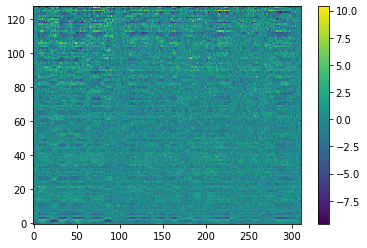

In [87]:
Y_noisy_noise = whiten_data.transform(noise_spec.T)

plot_spectogram(Y_noisy_noisy.T)

#### Use of whitenning when the data distribution has changed

Rotates, shifts and scales the given data distribution along the axes that are decorrelated and zero mean for the original data distribution.